In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.__version__

'2.9.0'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir="fer2013plus/fer2013/train/"
test_dir="fer2013plus/fer2013/test/"


train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=128,
                                               target_size=(48,48),
                                               class_mode="categorical",
                                               seed=42)
test_data = test_datagen.flow_from_directory(test_dir,
                                             batch_size=128,
                                             target_size=(48,48),
                                             class_mode="categorical",
                                             seed=42)

Found 28386 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.


In [4]:
#Callback functions
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    
    min_delta=0.0001,      
    patience=4,            
    verbose=1,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  #val_loss no overfitting   
    min_delta=0.0001,  
    mode="min",
    factor=0.5,                 
    patience=4,                 
    min_lr=1e-7,                
    verbose=1                   
)

# checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", monitor='val_accuracy', 
#                          verbose=1, save_best_only=True, mode='max')

In [5]:
# VGG 19
# 1. Create a base model with tf.keras.applciations
base_model1 = tf.keras.applications.VGG16(include_top=False, input_shape=(48,48,3)) # include_top -> last layer (will be different for different datasets)
base_model2 = tf.keras.applications.VGG19(include_top=False, input_shape=(48,48,3))
# 2. Freeze the base model, underlying pre-trained weights arent updated during training
base_model1.trainable=False
base_model2.trainable=False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(48,48,3),
                               name="input_layer")

# 4. (Optional) -> if using resnet -> need to normalize inputs -> not needed for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to base_model
x1 = base_model1(inputs)
x2 = base_model2(inputs)

# print("shape after passing inputs through base_model: "+str(x.shape))

# 6. Average pool the outputs of the base_model (aggregate all most of information, reduce number of computations)
x1 = tf.keras.layers.GlobalAveragePooling2D(name="average_global_pooling_layer")(x1)
x2 = tf.keras.layers.GlobalAveragePooling2D(name="average_global_pooling_layer")(x2)

# print("Shape after GlobalAveragePooling2D: "+str(x.shape))

# 7. Create the output activation layer
outputs1 = tf.keras.layers.Dense(8,activation=tf.keras.activations.softmax,name="output_layers")(x1)
outputs2 = tf.keras.layers.Dense(8,activation=tf.keras.activations.softmax,name="output_layers")(x2)

# 8. Combine input with the outputs into a model
model_vgg16 = tf.keras.Model(inputs,outputs1)
model_vgg19 = tf.keras.Model(inputs,outputs2)

# 9. Compile the model
model_vgg16.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_vgg16 = model_vgg16.fit(train_data,
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[lr_scheduler,early_stopping])


# 9. Compile the model
model_vgg19.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_vgg19 = model_vgg19.fit(train_data,
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[lr_scheduler,early_stopping])

Epoch 1/100
222/222 [==============================] - 12s 50ms/step - loss: 1.4790 - accuracy: 0.4336 - val_loss: 1.4027 - val_accuracy: 0.4751 - lr: 0.0010
Epoch 2/100
222/222 [==============================] - 10s 47ms/step - loss: 1.3607 - accuracy: 0.4888 - val_loss: 1.3582 - val_accuracy: 0.4946 - lr: 0.0010
Epoch 3/100
222/222 [==============================] - 10s 47ms/step - loss: 1.3256 - accuracy: 0.5016 - val_loss: 1.3370 - val_accuracy: 0.5018 - lr: 0.0010
Epoch 4/100
222/222 [==============================] - 10s 47ms/step - loss: 1.3029 - accuracy: 0.5082 - val_loss: 1.3211 - val_accuracy: 0.5096 - lr: 0.0010
Epoch 5/100
221/222 [============================>.] - ETA: 0s - loss: 1.2873 - accuracy: 0.5170
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
222/222 [==============================] - 11s 47ms/step - loss: 1.2866 - accuracy: 0.5173 - val_loss: 1.3094 - val_accuracy: 0.5150 - lr: 0.0010
Epoch 6/100
222/222 [============================

In [6]:
# VGG 19
# 1. Create a base model with tf.keras.applciations
base_model1 = tf.keras.applications.ResNet50V2(include_top=False, input_shape=(48,48,3)) # include_top -> last layer (will be different for different datasets)
# base_model2 = tf.keras.applications.VGG19(include_top=False, input_shape=(48,48,3))
# 2. Freeze the base model, underlying pre-trained weights arent updated during training
base_model1.trainable=False
# base_model2.trainable=False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(48,48,3),
                               name="input_layer")

# 4. (Optional) -> if using resnet -> need to normalize inputs -> not needed for EfficientNet
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to base_model
x1 = base_model1(inputs)

# print("shape after passing inputs through base_model: "+str(x.shape))

# 6. Average pool the outputs of the base_model (aggregate all most of information, reduce number of computations)
x1 = tf.keras.layers.GlobalAveragePooling2D(name="average_global_pooling_layer")(x1)
# x2 = tf.keras.layers.GlobalAveragePooling2D(name="average_global_pooling_layer")(x2)

# print("Shape after GlobalAveragePooling2D: "+str(x.shape))

# 7. Create the output activation layer
outputs1 = tf.keras.layers.Dense(8,activation=tf.keras.activations.softmax,name="output_layers")(x1)
# outputs2 = tf.keras.layers.Dense(8,activation=tf.keras.activations.softmax,name="output_layers")(x2)

# 8. Combine input with the outputs into a model
model_resnet = tf.keras.Model(inputs,outputs1)
# model_vgg19 = tf.keras.Model(inputs,outputs2)

# 9. Compile the model
model_resnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_resnet = model_resnet.fit(train_data,
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[lr_scheduler,early_stopping])


Epoch 1/100
222/222 [==============================] - 11s 39ms/step - loss: 1.6670 - accuracy: 0.4196 - val_loss: 1.4350 - val_accuracy: 0.4823 - lr: 0.0010
Epoch 2/100
222/222 [==============================] - 7s 32ms/step - loss: 1.3381 - accuracy: 0.4963 - val_loss: 1.4099 - val_accuracy: 0.4823 - lr: 0.0010
Epoch 3/100
222/222 [==============================] - 7s 32ms/step - loss: 1.2598 - accuracy: 0.5287 - val_loss: 1.4021 - val_accuracy: 0.4960 - lr: 0.0010
Epoch 4/100
222/222 [==============================] - 7s 33ms/step - loss: 1.2166 - accuracy: 0.5438 - val_loss: 1.3247 - val_accuracy: 0.5181 - lr: 0.0010
Epoch 5/100
222/222 [==============================] - ETA: 0s - loss: 1.1863 - accuracy: 0.5521
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
222/222 [==============================] - 7s 32ms/step - loss: 1.1863 - accuracy: 0.5521 - val_loss: 1.3605 - val_accuracy: 0.5044 - lr: 0.0010
Epoch 6/100
222/222 [==============================] 

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir="fer2013plus/fer2013/train/"
test_dir="fer2013plus/fer2013/test/"


train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=128,
                                               target_size=(48,48),
                                               class_mode="categorical",
                                               seed=42)
test_data = test_datagen.flow_from_directory(test_dir,
                                             batch_size=128,
                                             target_size=(48,48),
                                             class_mode="categorical",
                                             seed=42)


# 1. Create a base model with tf.keras.applciations
base_model1 = tf.keras.applications.EfficientNetB4(include_top=False, input_shape=(48,48,3)) # include_top -> last layer (will be different for different datasets)
# base_model2 = tf.keras.applications.VGG19(include_top=False, input_shape=(48,48,3))
# 2. Freeze the base model, underlying pre-trained weights arent updated during training
base_model1.trainable=False
# base_model2.trainable=False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(48,48,3),
                               name="input_layer")

# 4. (Optional) -> if using resnet -> need to normalize inputs -> not needed for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to base_model
x1 = base_model1(inputs)

# print("shape after passing inputs through base_model: "+str(x.shape))

# 6. Average pool the outputs of the base_model (aggregate all most of information, reduce number of computations)
x1 = tf.keras.layers.GlobalAveragePooling2D(name="average_global_pooling_layer")(x1)
# x2 = tf.keras.layers.GlobalAveragePooling2D(name="average_global_pooling_layer")(x2)

# print("Shape after GlobalAveragePooling2D: "+str(x.shape))

# 7. Create the output activation layer
outputs1 = tf.keras.layers.Dense(8,activation=tf.keras.activations.softmax,name="output_layers")(x1)
# outputs2 = tf.keras.layers.Dense(8,activation=tf.keras.activations.softmax,name="output_layers")(x2)

# 8. Combine input with the outputs into a model
model_eff_4 = tf.keras.Model(inputs,outputs1)
# model_vgg19 = tf.keras.Model(inputs,outputs2)

# 9. Compile the model
model_eff_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_eff_4 = model_eff_4.fit(train_data,
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[lr_scheduler,early_stopping])


Found 28386 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.
Epoch 1/100
222/222 [==============================] - 20s 64ms/step - loss: 1.6172 - accuracy: 0.3550 - val_loss: 1.6127 - val_accuracy: 0.3658 - lr: 0.0010
Epoch 2/100
222/222 [==============================] - 13s 57ms/step - loss: 1.6127 - accuracy: 0.3527 - val_loss: 1.6188 - val_accuracy: 0.3658 - lr: 0.0010
Epoch 3/100
222/222 [==============================] - 13s 57ms/step - loss: 1.6108 - accuracy: 0.3575 - val_loss: 1.6234 - val_accuracy: 0.3658 - lr: 0.0010
Epoch 4/100
222/222 [==============================] - 13s 57ms/step - loss: 1.6123 - accuracy: 0.3534 - val_loss: 1.6141 - val_accuracy: 0.3658 - lr: 0.0010
Epoch 5/100
221/222 [============================>.] - ETA: 0s - loss: 1.6111 - accuracy: 0.3545
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Restoring model weights from the end of the best epoch: 1.
222/222 [==============================] - 13s 58ms

In [8]:
model_eff_4.layers[1].name

'efficientnetb4'

In [9]:
history_eff_4.history

{'loss': [1.6172040700912476,
  1.6127369403839111,
  1.6108163595199585,
  1.612305760383606,
  1.6109644174575806],
 'accuracy': [0.35499894618988037,
  0.35267385840415955,
  0.3574649393558502,
  0.35337841510772705,
  0.35454097390174866],
 'val_loss': [1.6126809120178223,
  1.6187567710876465,
  1.6233959197998047,
  1.6141363382339478,
  1.6263082027435303],
 'val_accuracy': [0.36582615971565247,
  0.36582615971565247,
  0.36582615971565247,
  0.36582615971565247,
  0.36582615971565247],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001]}

In [14]:
model_names=["vgg16","vgg19","effnetb4","resnet"]

In [15]:
import pandas as pd
def save_csv(hist=[],model_names=[]):
    for i in range(len(hist)):
        pd.DataFrame(hist[i].history).to_csv(f'history/hist{model_names[i]}')

In [16]:
save_csv([history_vgg16,history_vgg19,history_eff_4,history_resnet],model_names)

In [1]:
import pickle as pk
with open('file.pkl', 'rb') as file:
      
    # Call load method to deserialze
    history_dcnn = pk.load(file)
  
    print(history_dcnn)

2023-08-14 19:04:13.851457: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-14 19:04:15.363693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 19:04:15.381621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 19:04:15.381759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 19:04:15.382493: I tensorflow/core/

In [22]:
history_dcnn.history

{'loss': [1.5211914777755737,
  1.0289682149887085,
  0.8539248704910278,
  0.7725116014480591,
  0.7083613872528076,
  0.6120865345001221,
  0.5656148195266724,
  0.5307382345199585,
  0.49736183881759644,
  0.42269113659858704,
  0.3852015435695648,
  0.3599364757537842,
  0.33289071917533875,
  0.2808707058429718,
  0.24455679953098297],
 'accuracy': [0.47270166873931885,
  0.6382088661193848,
  0.6935540437698364,
  0.7255195379257202,
  0.7496037483215332,
  0.7845191955566406,
  0.8016907572746277,
  0.8116413950920105,
  0.8217682242393494,
  0.8494628667831421,
  0.8630679845809937,
  0.8724462985992432,
  0.8800634145736694,
  0.8978953957557678,
  0.9138781428337097],
 'val_loss': [1.3328057527542114,
  1.0972977876663208,
  0.852575957775116,
  0.8722752928733826,
  1.351462483406067,
  0.7148497700691223,
  0.6702989935874939,
  0.6665971279144287,
  0.7109628915786743,
  0.6508536338806152,
  0.6024495363235474,
  0.6347486972808838,
  0.6615105867385864,
  0.6421643495559

In [23]:
import pandas as pd
hist_vgg_16=pd.read_csv("history/histvgg16")
hist_vgg_16=hist_vgg_16.drop("Unnamed: 0",axis=1).to_dict()

hist_vgg_19=pd.read_csv("history/histvgg19")
hist_vgg_19=hist_vgg_19.drop("Unnamed: 0",axis=1).to_dict()

hist_resnet=pd.read_csv("history/histresnet")
hist_resnet=hist_resnet.drop("Unnamed: 0",axis=1).to_dict()

hist_effnetb4=pd.read_csv("history/histeffnetb4")
hist_effnetb4=hist_effnetb4.drop("Unnamed: 0",axis=1).to_dict()


In [34]:
hist=[hist_resnet,history_vgg_16,hist_vgg_19,hist_effnetb4,history_dcnn.history]

In [24]:
model_names=["resnet","vgg16",'vgg19',"efficientNetb4","Proposed DCNN"]

TypeError: float() argument must be a string or a number, not 'dict'

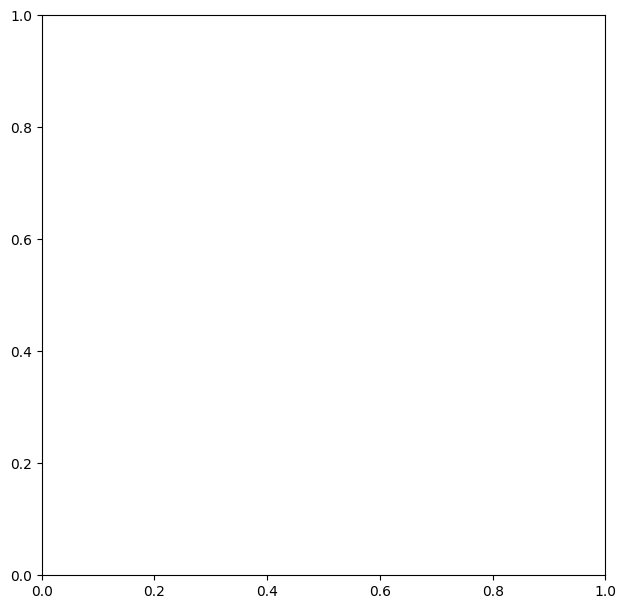

In [35]:
import matplotlib.pyplot as plt
def plot_hi(hist=[],model=[]):
    val_acc=[]
    val_loss=[]
    loss=[]
    accuracy=[]
    metrics=[val_acc,accuracy,val_loss,loss]
    metrics_title=["val_acc","accuracy","val_loss","loss"]
    for history in hist:
        accuracy.append(history["accuracy"])
        val_acc.append(history["val_accuracy"])
        loss.append(history["loss"])
        val_loss.append(history["val_loss"])
    
    plt.figure(figsize=(16,16))
    c=['g','r','b','orange',"black"]
    for j in range(len(metrics)):
        plt.subplot(2,2,j+1)
        for i in range(len(hist)):
            plt.plot(metrics[j][i],c=c[i],label=model[i])
        plt.title(metrics_title[j])
        plt.legend()
        plt.savefig(f"plot_model/{metrics_title[j]}")

    plt.show()
plot_hi(hist, model_names)

In [29]:
y_pred_vgg16 = model_vgg19.predict(test_data)
y_pred_vgg19 = model_vgg19.predict(test_data)
y_pred_resnet = model_resnet.predict(test_data)
y_pred_effnetb4 = model_eff_4.predict(test_data)

 1/56 [..............................] - ETA: 2s

56/56 [==============================] - 4s 63ms/step


In [30]:
y_pred_vgg16 = tf.argmax(y_pred_vgg16,axis=1)
y_pred_vgg19 = tf.argmax(y_pred_vgg19,axis=1)
y_pred_resnet = tf.argmax(y_pred_resnet,axis=1)
y_pred_effnetb4 = tf.argmax(y_pred_effnetb4,axis=1)

In [26]:
from helper_functions import calculate_results
print("vgg16",calculate_results(test_data.labels,y_pred_vgg16.numpy()))
print(calculate_results(test_data.labels,y_pred_vgg19.numpy()))
print(calculate_results(test_data.labels,y_pred_resnet.numpy()))
print(calculate_results(test_data.labels,y_pred_effnetb4.numpy()))

{'accuracy': 28.257501056486827, 'precision': 0.2290343208438146, 'recall': 0.28257501056486833, 'f1': 0.24719325042904855}
{'accuracy': 29.48302577827863, 'precision': 0.24518252371213622, 'recall': 0.2948302577827863, 'f1': 0.26001958053808644}
{'accuracy': 27.00380335258487, 'precision': 0.24050591370291752, 'recall': 0.2700380335258487, 'f1': 0.2520829492907257}
{'accuracy': 36.58261727003803, 'precision': 0.1338287886326085, 'recall': 0.3658261727003803, 'f1': 0.19596752691891248}


/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
model_dcnn = tf.keras.models.load_model("high")
model_dcnn.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0      

In [32]:
calculate_results(test_data.labels, tf.argmax(model_dcnn.predict(test_data),axis=1).numpy())

NotFoundError: Graph execution error:

Detected at node 'DCNN/conv2d_1/Conv2D' defined at (most recent call last):
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_149414/1780590433.py", line 1, in <module>
      calculate_results(test_data.labels, tf.argmax(model_dcnn.predict(test_data),axis=1).numpy())
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'DCNN/conv2d_1/Conv2D'
No algorithm worked!  Error messages:
	 [[{{node DCNN/conv2d_1/Conv2D}}]] [Op:__inference_predict_function_189049]